In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,  Lasso, Ridge, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression


## HELPER FUNCTIONS TO BE ADDED IN A .PY FILE

In [18]:
## HELPER FUNCTIONS

# Function to label encode the categorical features of a df
def label_encode(X):
    X_label = X.copy()
    for colname in X_label.select_dtypes(["category", "object"]):
        X_label[colname], _ = pd.factorize(X_label[colname])
    return X_label

# Function to evaluate a model with cross-validation
def evaluate_model(X, y, model, return_trained_model=True):
    """
    Evaluate a model with cross-validation and return both MAE and RMSLE in original scale (USD).
    Optionally returns a model trained on the full dataset.
    Detects if model is a pipeline and avoids double encoding.
    """
    log_y = np.log1p(y)  # Transform target to log scale

    # Cross-validation predictions
    preds_log = cross_val_predict(model, X, log_y, cv=5)
    preds = np.expm1(preds_log)  # Convert predictions back to original scale

    mae = mean_absolute_error(y, preds)
    rmsle = np.sqrt(mean_squared_error(log_y, preds_log))

    if return_trained_model:
        model.fit(X, log_y)
        return mae, rmsle, model
    else:
        return mae, rmsle


##############################
# Functions to create pipelines including a class to create products and ratios between features
##############################

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin




##############################################
# 1. Preprocessor builder (numeric + categorical)
##############################################
def create_preprocessor(numeric_columns, categorical_columns=None, encoding="label", log_columns=None):
    numeric_transformers = []

    if log_columns and len(log_columns) > 0:
        log_transformer = Pipeline([
            ('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False)),
            ('scaler', StandardScaler())
        ])
        numeric_transformers.append(('log', log_transformer, log_columns))

        remaining_cols = [col for col in numeric_columns if col not in log_columns]
        if remaining_cols:
            numeric_transformers.append(('num', Pipeline([('scaler', StandardScaler())]), remaining_cols))
    else:
        numeric_transformers.append(('num', Pipeline([('scaler', StandardScaler())]), numeric_columns))

    transformers = numeric_transformers

    if categorical_columns and len(categorical_columns) > 0:
        if encoding == "label":
            categorical_transformer = Pipeline([('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        elif encoding == "onehot":
            categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
        else:
            raise ValueError("encoding must be 'label' or 'onehot'")
        transformers.append(('cat', categorical_transformer, categorical_columns))

    preprocessor = ColumnTransformer(transformers=transformers)
    return preprocessor


##########################################
# 2. PIPELINE CREATORS FOR EACH MODEL   #
##########################################
def create_linear_pipeline(numeric_columns, categorical_columns=None, encoding="label", log_columns=None):
    preprocessor = create_preprocessor(numeric_columns, categorical_columns, encoding, log_columns)

    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

def create_lasso_pipeline(numeric_columns, categorical_columns=None, encoding="label", log_columns=None,
                          alpha=0.01):
    preprocessor = create_preprocessor(numeric_columns, categorical_columns, encoding, log_columns)
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha, random_state=0))
    ])

def create_ridge_pipeline(numeric_columns, categorical_columns=None, encoding="label", log_columns=None,
                          alpha=0.01):
    preprocessor = create_preprocessor(numeric_columns, categorical_columns, encoding, log_columns)

    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=alpha, random_state=0))
    ])

def create_elasticnet_pipeline(numeric_columns, categorical_columns=None, encoding="label", log_columns=None,
                               alpha=0.01, l1_ratio=0.5):
    preprocessor = create_preprocessor(numeric_columns, categorical_columns, encoding, log_columns)
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=0))
    ])


################ Evaluate all linear-based models ################
def evaluate_all_linear(X, y, numeric_columns, categorical_columns=None, log_columns=None,
                        alpha=0.001, l1_ratio=0.5):
    """
    Evaluates Linear, Lasso, Ridge, and ElasticNet models using both label and onehot encoding.
    """
    # ---------------- Linear Regression ----------------
    linear_label = create_linear_pipeline(numeric_columns, categorical_columns, encoding='label',
                                          log_columns=log_columns,)
    linear_label_mae, linear_label_rmsle = evaluate_model(X, y, linear_label, return_trained_model=False)

    linear_onehot = create_linear_pipeline(numeric_columns, categorical_columns, encoding='onehot',
                                           log_columns=log_columns)
    linear_onehot_mae, linear_onehot_rmsle = evaluate_model(X, y, linear_onehot, return_trained_model=False)

    # ---------------- Lasso Regression ----------------
    lasso_label = create_lasso_pipeline(numeric_columns, categorical_columns, encoding='label',
                                        log_columns=log_columns, alpha=alpha)
    lasso_label_mae, lasso_label_rmsle = evaluate_model(X, y, lasso_label, return_trained_model=False)

    lasso_onehot = create_lasso_pipeline(numeric_columns, categorical_columns, encoding='onehot',
                                         log_columns=log_columns, alpha=alpha)
    lasso_onehot_mae, lasso_onehot_rmsle = evaluate_model(X, y, lasso_onehot, return_trained_model=False)

    # ---------------- Ridge Regression ----------------
    ridge_label = create_ridge_pipeline(numeric_columns, categorical_columns, encoding='label',
                                        log_columns=log_columns, alpha=alpha)
    ridge_label_mae, ridge_label_rmsle = evaluate_model(X, y, ridge_label, return_trained_model=False)

    ridge_onehot = create_ridge_pipeline(numeric_columns, categorical_columns, encoding='onehot',
                                         log_columns=log_columns, alpha=alpha)
    ridge_onehot_mae, ridge_onehot_rmsle = evaluate_model(X, y, ridge_onehot, return_trained_model=False)

    # ---------------- ElasticNet Regression ----------------
    en_label = create_elasticnet_pipeline(numeric_columns, categorical_columns, encoding='label',
                                          log_columns=log_columns, alpha=alpha, l1_ratio=l1_ratio)
    en_label_mae, en_label_rmsle = evaluate_model(X, y, en_label, return_trained_model=False)

    en_onehot = create_elasticnet_pipeline(numeric_columns, categorical_columns, encoding='onehot',
                                          log_columns=log_columns, alpha=alpha, l1_ratio=l1_ratio)
    en_onehot_mae, en_onehot_rmsle = evaluate_model(X, y, en_onehot, return_trained_model=False)

    # ---------------- Print results -------------------------
    print(f'Linear label encoding:      MAE: {linear_label_mae} | RMSLE: {linear_label_rmsle}')
    print(f'Linear onehot encoding:     MAE: {linear_onehot_mae} | RMSLE: {linear_onehot_rmsle}')
    print(f'Lasso label encoding:       MAE: {lasso_label_mae}  | RMSLE: {lasso_label_rmsle}')
    print(f'Lasso onehot encoding:      MAE: {lasso_onehot_mae} | RMSLE: {lasso_onehot_rmsle}')
    print(f'Ridge label encoding:       MAE: {ridge_label_mae}  | RMSLE: {ridge_label_rmsle}')
    print(f'Ridge onehot encoding:      MAE: {ridge_onehot_mae} | RMSLE: {ridge_onehot_rmsle}')
    print(f'ElasticNet label encoding:  MAE: {en_label_mae}  | RMSLE: {en_label_rmsle}')
    print(f'ElasticNet onehot encoding: MAE: {en_onehot_mae} | RMSLE: {en_onehot_rmsle}')


###################### Extract and plot coefficients for Linear Regression model ###########

### Extract coeficients by order of absolute value
def get_coef_signed(pipeline):
    """
    Extract feature names and coefficients from a linear pipeline
    (LinearRegression, Lasso, Ridge, ElasticNet).
    """
    # Extract the preprocessor and regressor from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    regressor = pipeline.named_steps['regressor']

    feature_names = []

    # Iterate over transformers in the ColumnTransformer
    for name, transformer, cols in preprocessor.transformers_:
        # If the transformer is a pipeline, take the last step
        if hasattr(transformer, 'named_steps'):
            trans = list(transformer.named_steps.values())[-1]
        else:
            trans = transformer

        # If the transformer provides feature names (e.g., OneHotEncoder)
        if hasattr(trans, "get_feature_names_out"):
            try:
                # Get feature names using the columns
                fn = trans.get_feature_names_out(cols)
            except TypeError:
                # Some transformers (like OneHotEncoder without input_features) may not accept cols
                fn = trans.get_feature_names_out()
            feature_names.extend(fn)
        else:
            # Transformers like log or scaler do not change feature names, keep original column names
            feature_names.extend(cols)

    # Create a DataFrame with features and their coefficients
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': regressor.coef_.ravel()
    })

    # Sort the DataFrame by absolute value of coefficients
    coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False).reset_index(drop=True)

    return coef_df




# Plot top coeficients
def plot_coeficients_importance(coef_df, top_n=20, title="Feature Importances"):
    """
    Plot the coefficients from get_coef_simple output.

    Parameters:
    -----------
    coef_df : pd.DataFrame
        Output from get_coef_simple (must have 'feature' and 'coefficient').
    top_n : int, optional
        Number of top features to plot (default=20).
    title : str, optional
        Plot title.
    """
    # Select top_n by absolute value
    coef_df_sorted = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)
    coef_df_top = coef_df_sorted.head(top_n)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(coef_df_top['feature'], coef_df_top['coefficient'], color="skyblue")
    plt.axvline(0, color='k', linestyle='--')
    plt.title(title)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # biggest on top

    # Color positive/negative
    for bar, val in zip(bars, coef_df_top['coefficient']):
        if val < 0:
            bar.set_color('salmon')

    plt.show()


# Function to get XGBoost feature importance as DataFrame
def get_xgb_feature_importance_df(XGB_model):
    """
    Return XGBoost feature importance as a DataFrame sorted by gain.

    Parameters:
    -----------
    XGB_model : trained XGBRegressor or XGBClassifier
        Trained XGBoost model
    top_n : int
        Number of top features to return

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['feature', 'gain'] sorted by gain descending
    """
    importance_dict = XGB_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'gain': list(importance_dict.values())
    }).sort_values(by='gain', ascending=False).reset_index(drop=True)

    return importance_df

# Function to plot XGBoost feature importance from a DataFrame
def plot_xgb_feature_importance(importance_df):
    """
    Plot XGBoost feature importance from a DataFrame.

    Parameters:
    -----------
    importance_df : pd.DataFrame
        DataFrame with columns ['feature', 'gain']
    """
    plt.figure(figsize=(10, max(6, 0.3*len(importance_df))))
    plt.barh(importance_df['feature'], importance_df['gain'], color='skyblue')
    plt.gca().invert_yaxis()  # largest gain at top
    plt.xlabel('Gain')
    plt.title(f'Top {len(importance_df)} XGBoost Features by Gain')
    plt.show()



# --- Function to compute MI scores ---
def get_mi_scores(X, y, discrete_features=None, top_n=None):
    """
    Compute mutual information (MI) scores for features in X against y.

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series or array-like
        Target vector
    discrete_features : list or boolean array, optional
        Specify which features are discrete/categorical
    top_n : int, optional
        If specified, return only the top_n features with highest MI

    Returns:
    --------
    pd.Series
        MI scores sorted descending
    """
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
    mi_scores = mi_scores.sort_values(ascending=False)
    if top_n is not None:
        mi_scores = mi_scores.iloc[:top_n]
    return mi_scores


# --- Function to plot MI scores ---
def plot_mi_scores(mi_scores, top_n=None):
    """
    Plot mutual information (MI) scores from a Series.

    Parameters:
    -----------
    mi_scores : pd.Series
        Series with MI scores indexed by feature names
    top_n : int, optional
        If specified, plot only the top_n features
    """
    if top_n is not None:
        mi_scores = mi_scores.iloc[:top_n]

    plt.figure(figsize=(10, max(4, 0.3*len(mi_scores))))
    mi_scores.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('Mutual Information')
    plt.title('Feature Importance via Mutual Information')
    plt.show()

####### Function to add interactions products and ratios
from itertools import combinations, permutations

def add_interactions(X, product_tuples=None, ratio_tuples=None, eps=1e-6, return_numeric_features=True):
    """
    Add product and ratio features efficiently to X based on given tuples.

    Parameters
    ----------
    X : pd.DataFrame
        Original DataFrame.
    product_tuples : list of tuples
        Tuples of columns to generate products (col1*col2).
    ratio_tuples : list of tuples
        Tuples of columns to generate ratios (col1/col2).
    eps : float
        Small value to avoid division by zero in ratios.
    return_numeric_features : bool
        If True, returns the list of numeric columns including the new interactions.

    Returns
    -------
    X_new : pd.DataFrame
        DataFrame with added interaction features.
    numeric_features (optional) : list
        List of numeric columns including newly created interactions (if return_numeric_features=True).
    """
    X_new = X.copy()
    new_features = {}

    # Create product features
    if product_tuples:
        for col1, col2 in product_tuples:
            new_features[f"{col1}*{col2}"] = X_new[col1] * X_new[col2]

    # Create ratio features
    if ratio_tuples:
        for col1, col2 in ratio_tuples:
            new_features[f"{col1}/{col2}"] = X_new[col1] / (X_new[col2] + eps)

    # Add new features to the DataFrame efficiently
    if new_features:
        X_new = pd.concat([X_new, pd.DataFrame(new_features, index=X.index)], axis=1)

    if return_numeric_features:
        # Combine original numeric columns with new interactions
        numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        numeric_cols += list(new_features.keys())
        return X_new, numeric_cols

    return X_new




# Feature exploring and Model Selection



In this notebook we will perform feature engeenering in the data set of the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. We alredy performed preprocessing on the data set by dealing with missing values and inconsistenices. The notebook for preprocessing is [here](https://github.com/Jsrodrigue/House-Prices---Advanced-Regression-Techniques/blob/main/notebooks/house_prices_preprocessing.ipynb).

In [20]:
# First we load the preprocessed train data

path_train = 'train_pre.csv'
df= pd.read_csv(path_train, keep_default_na=False)

# Get predictors and target
X = df.copy()
y = X.pop("SalePrice")

# Select numerical and categorical features
numeric_features_all = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_features_all = list(X.select_dtypes(include=["object", "category"]).columns)
X.shape

(1440, 73)

In [21]:
# Create a df X with labels in the categorical features
X_label = label_encode(X)

## Linear regression baseline

Now lets train and compute the errors of linear regression baselines using onehot encoding and ordinal encoding, with linear o lasso regressor. We apply logaritmic scale to the features with high outliers.




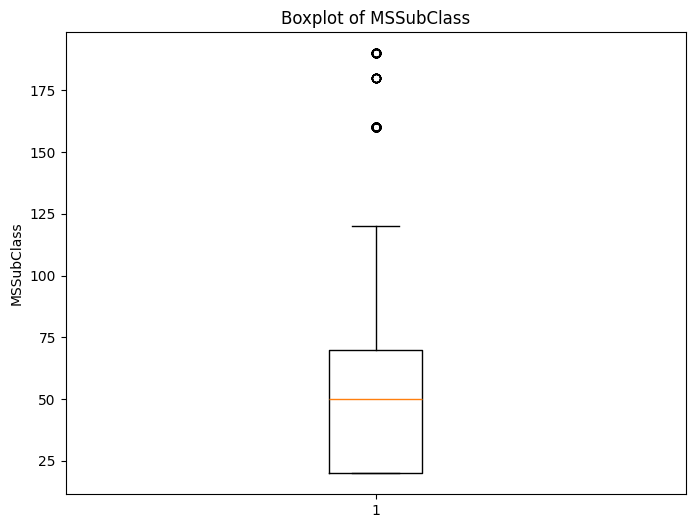

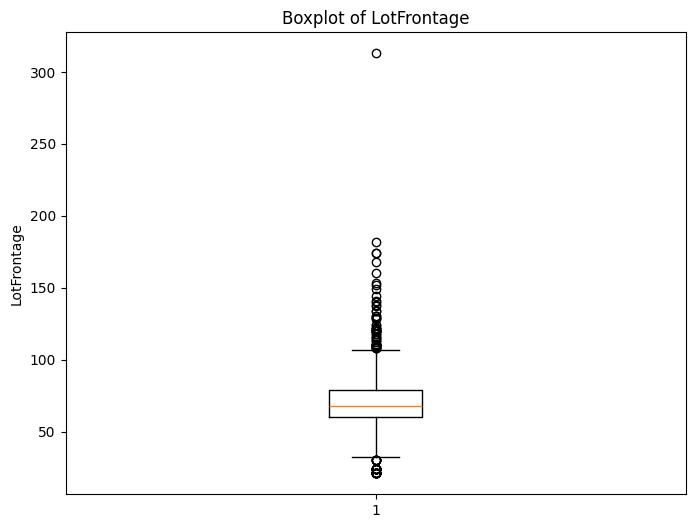

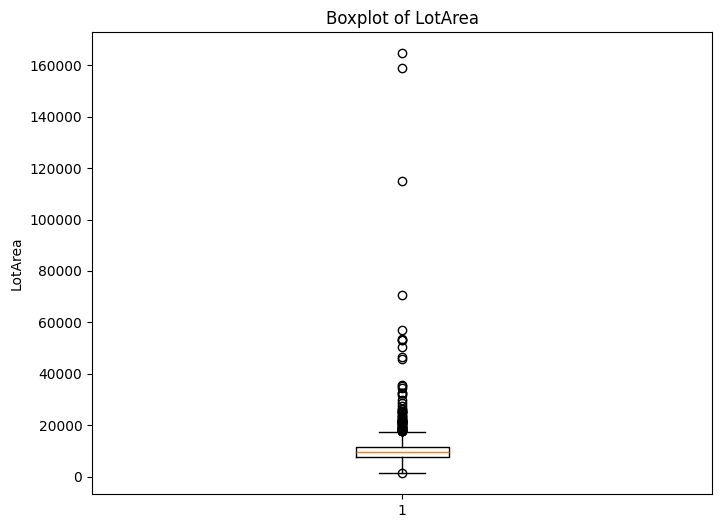

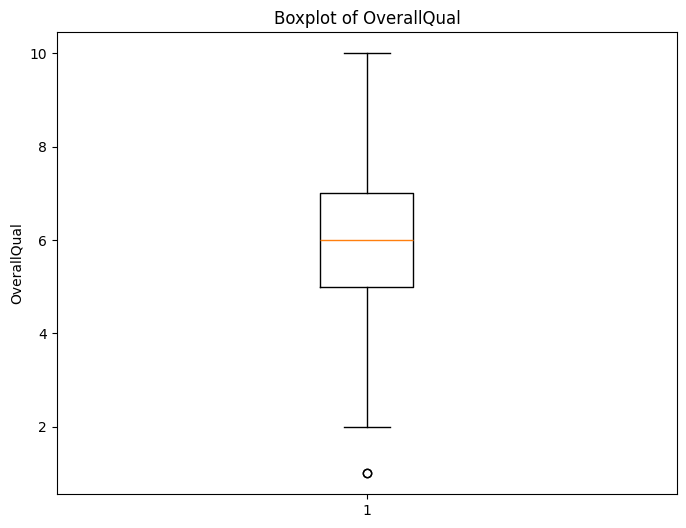

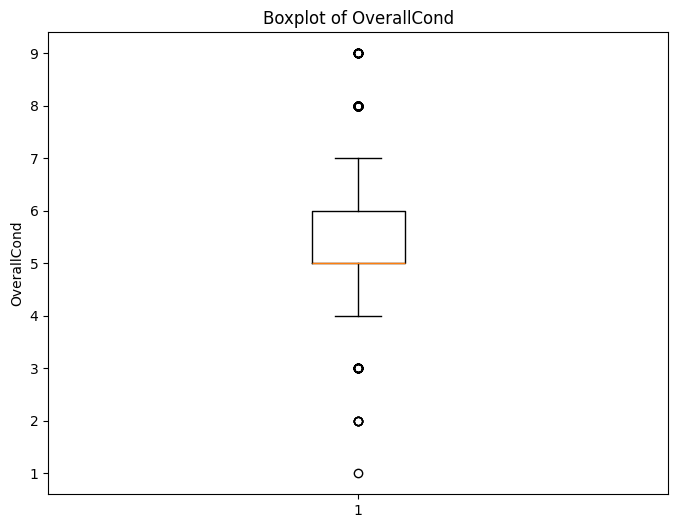

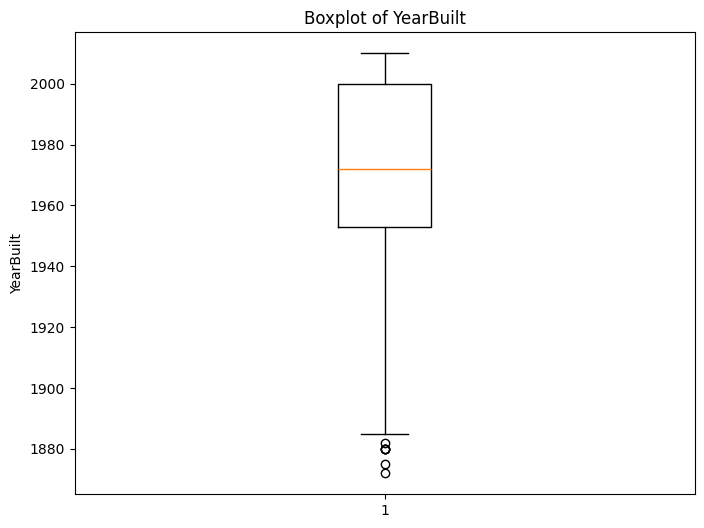

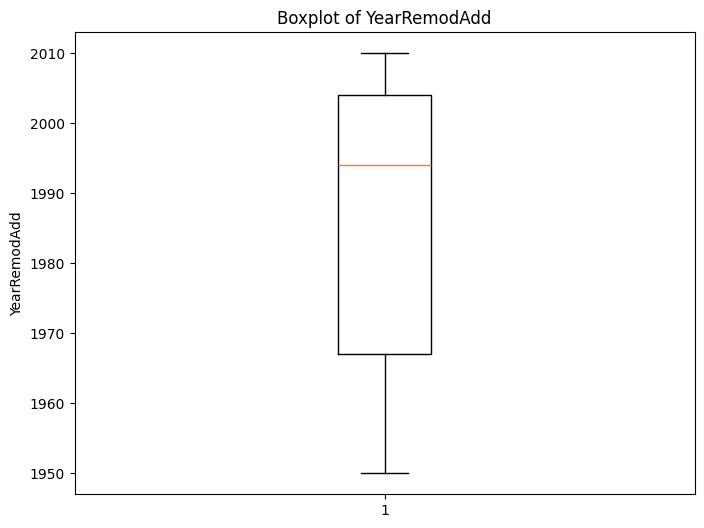

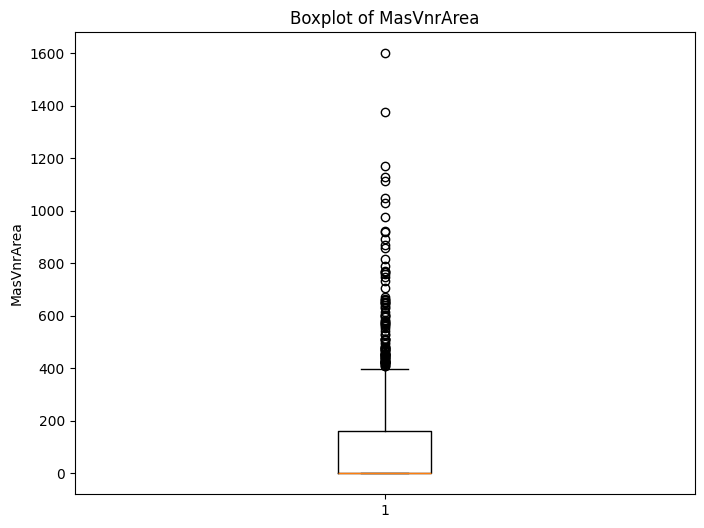

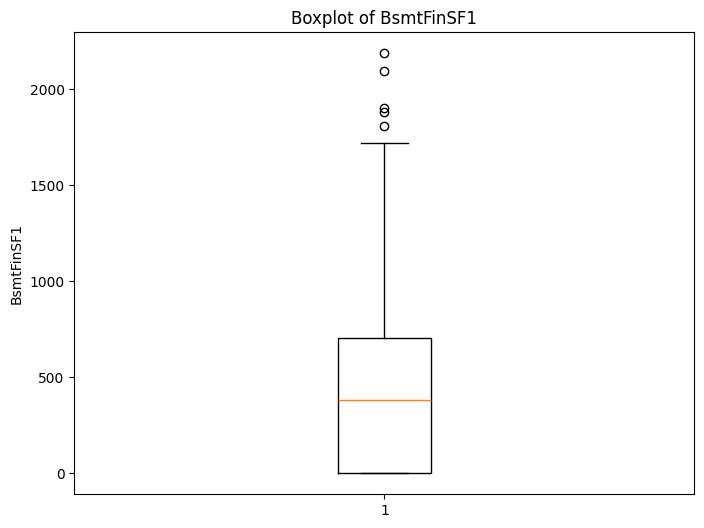

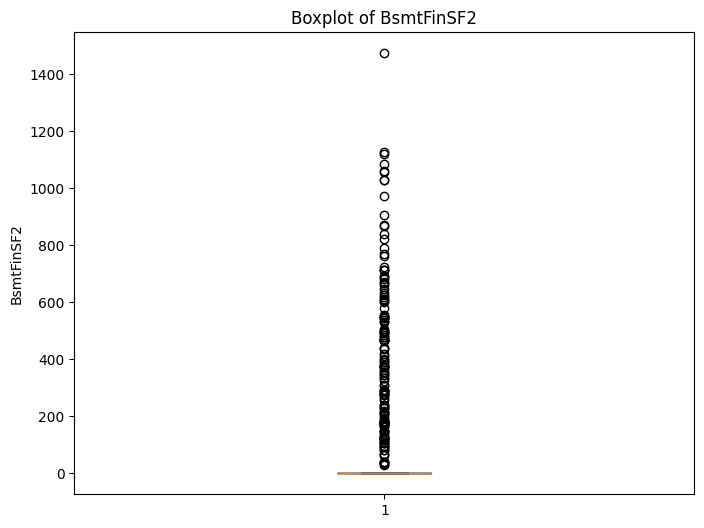

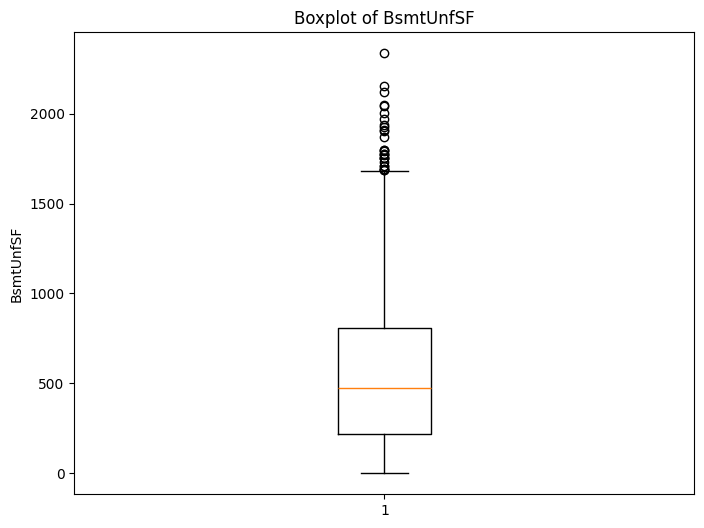

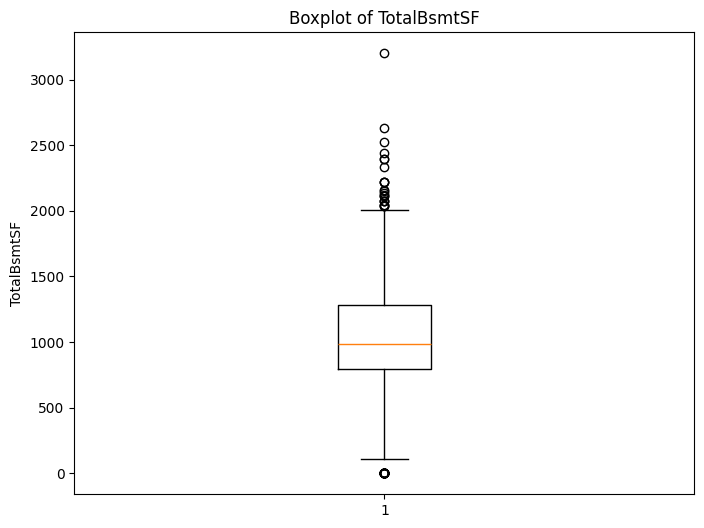

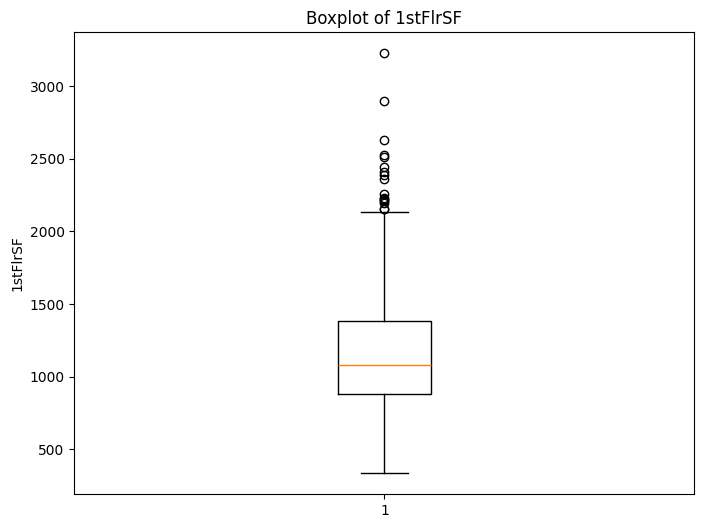

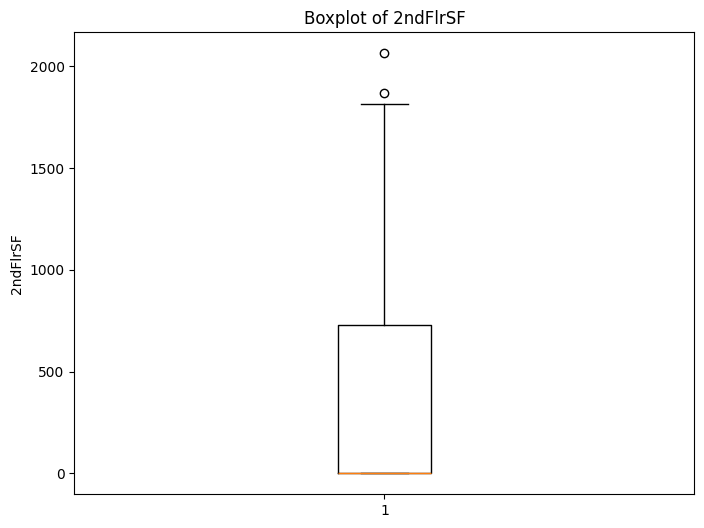

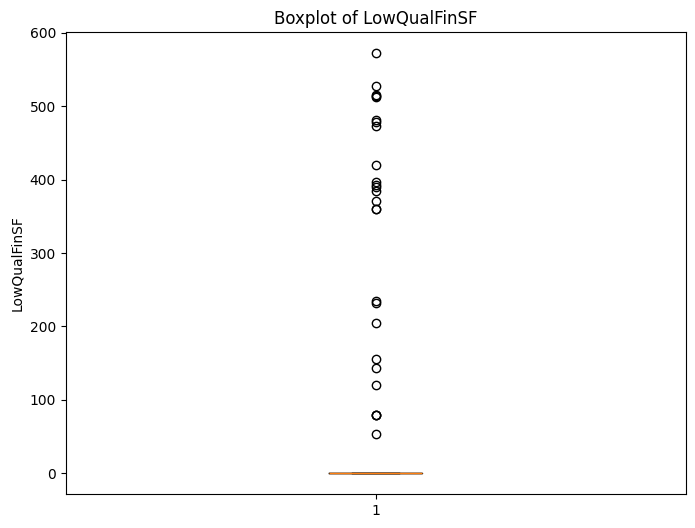

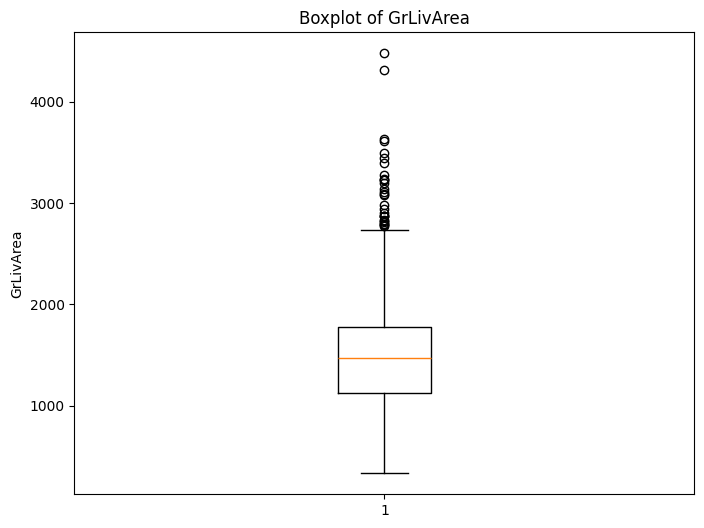

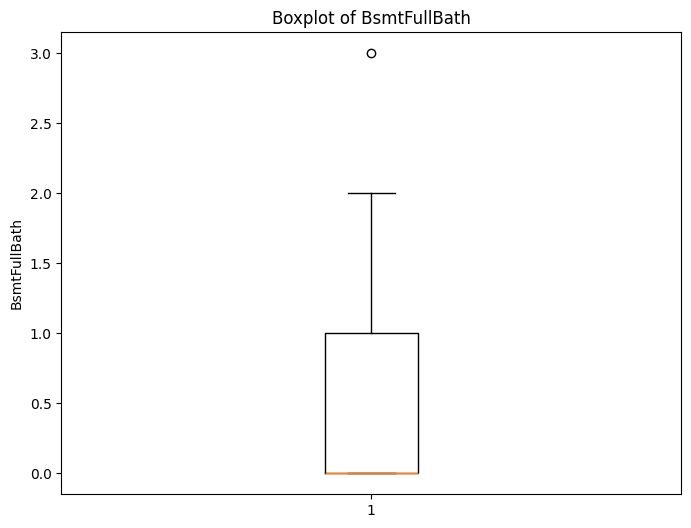

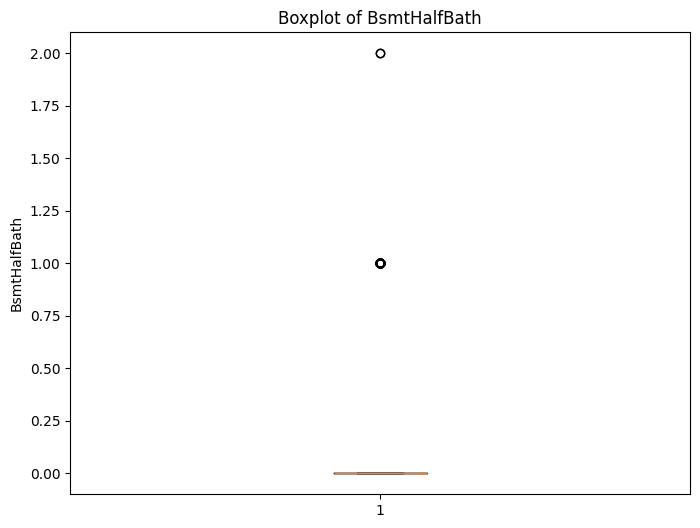

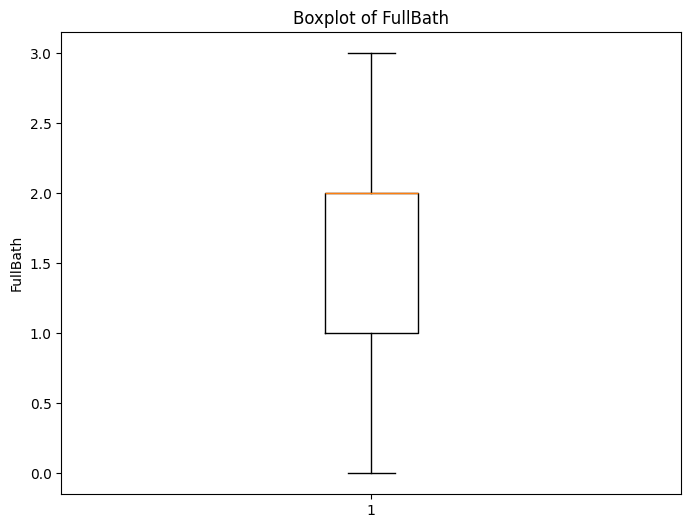

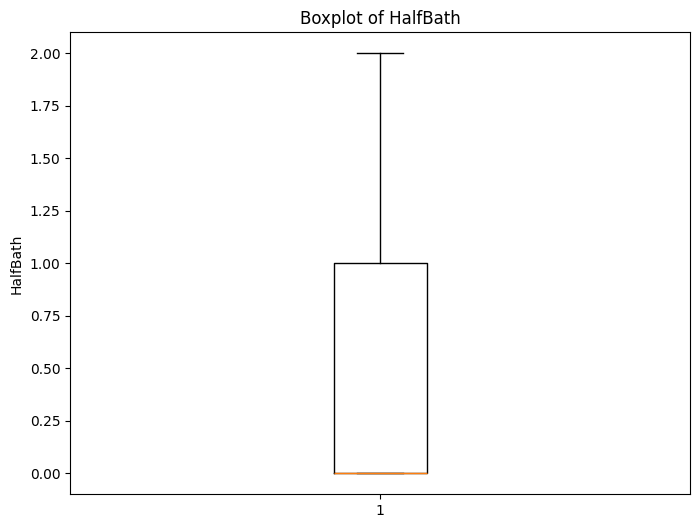

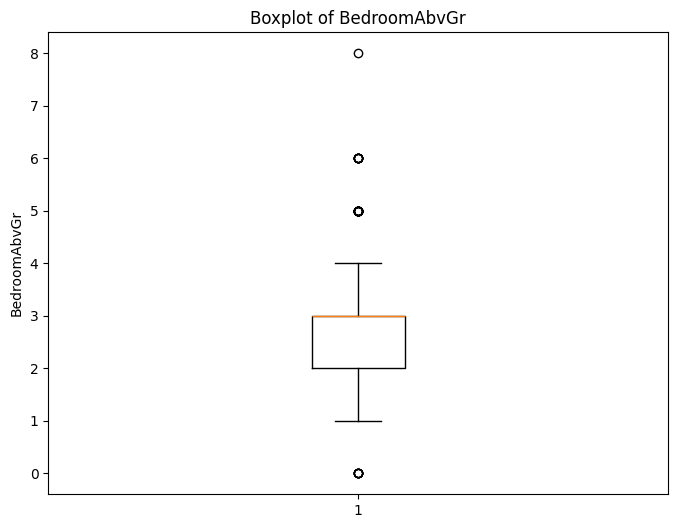

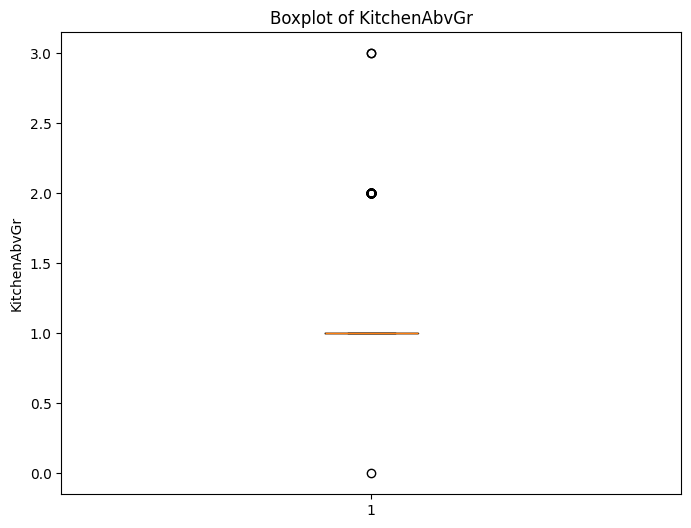

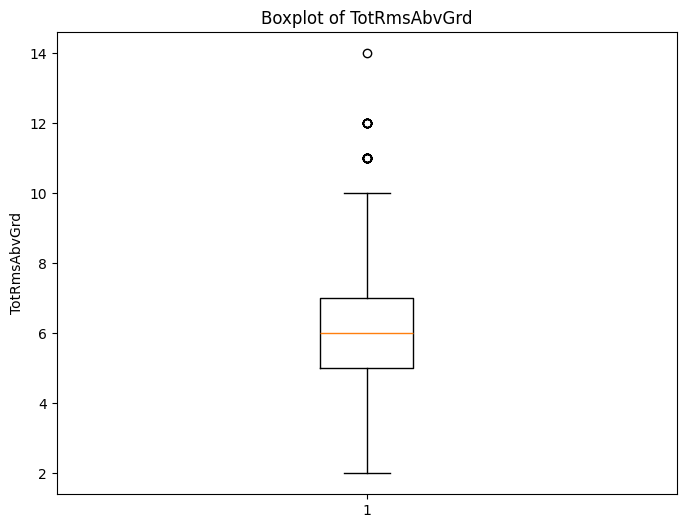

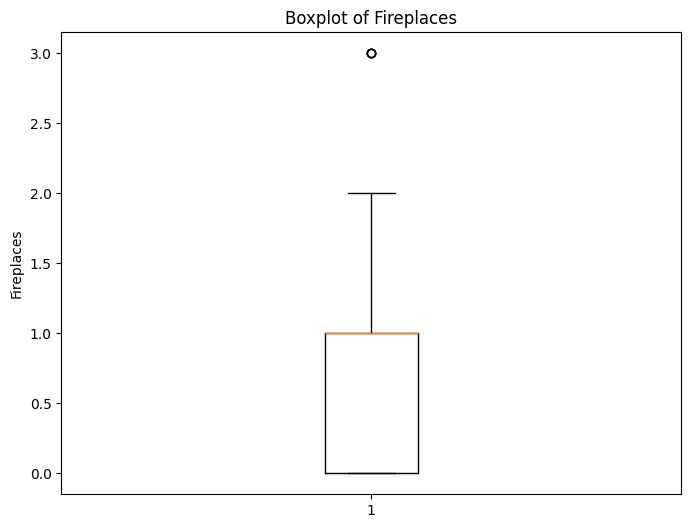

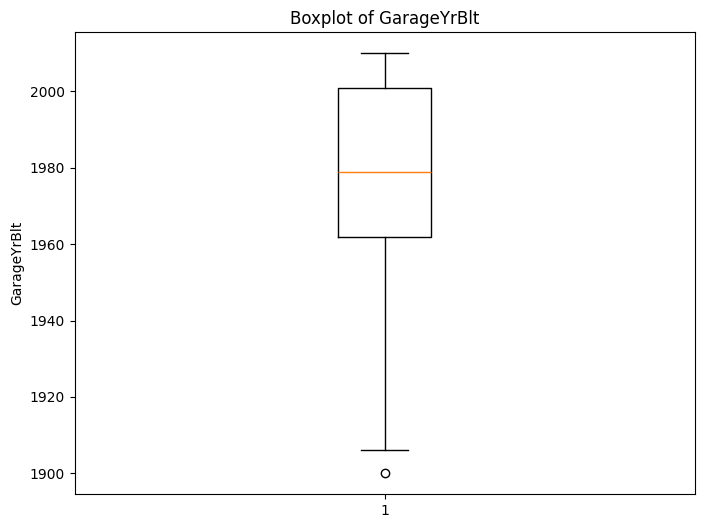

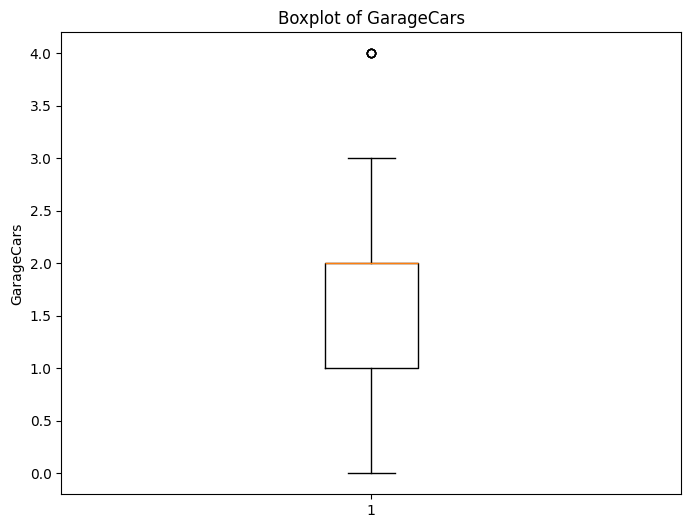

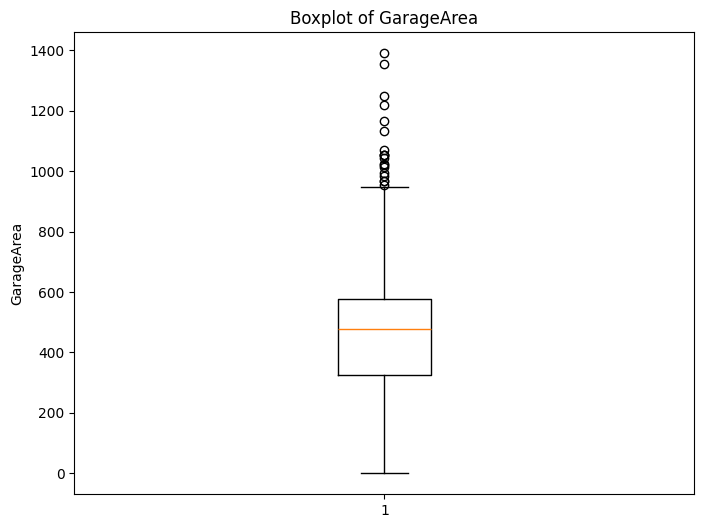

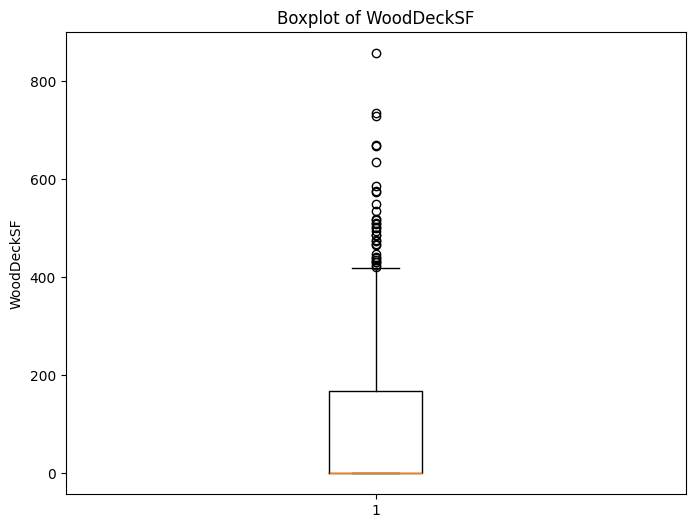

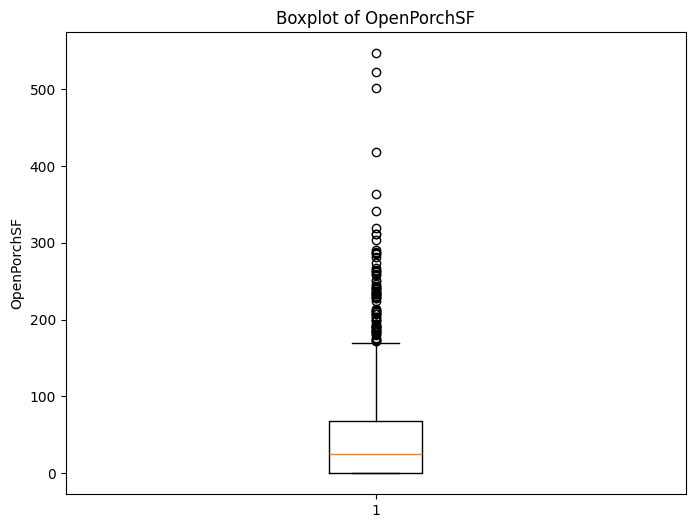

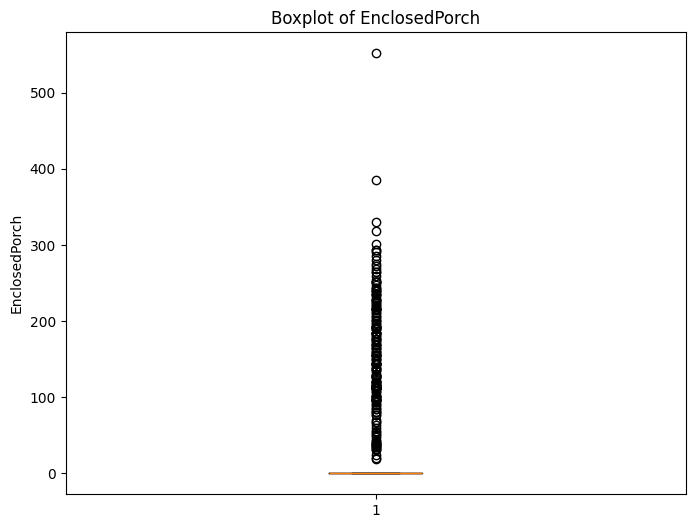

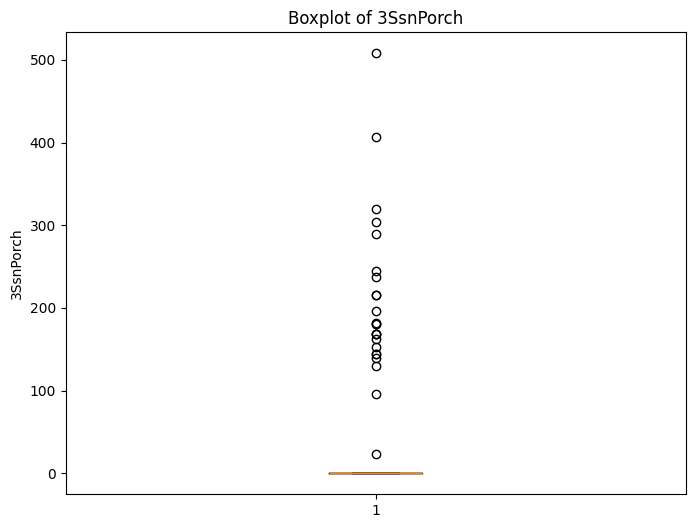

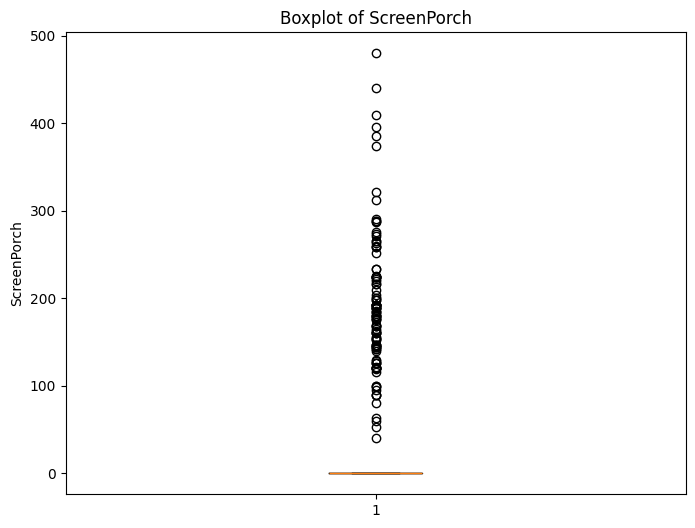

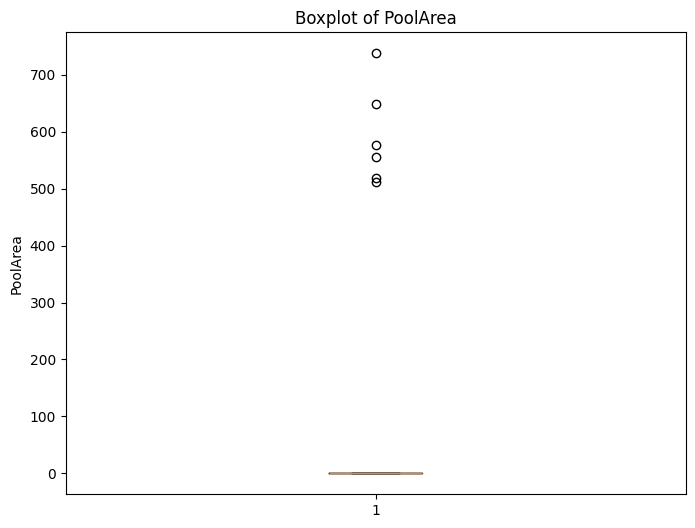

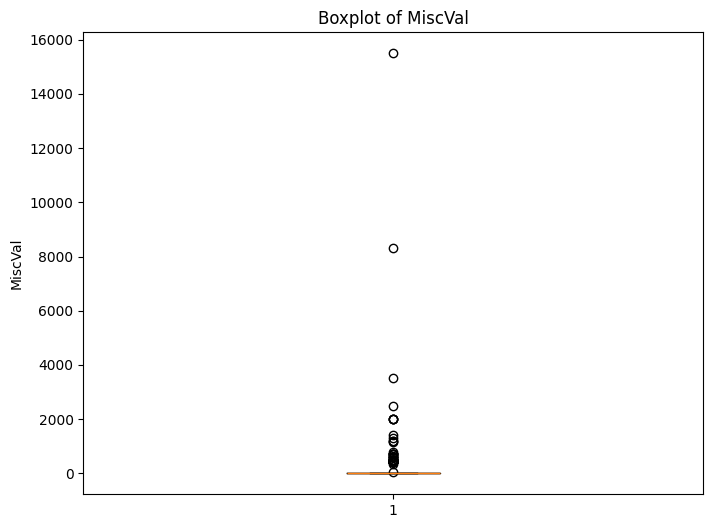

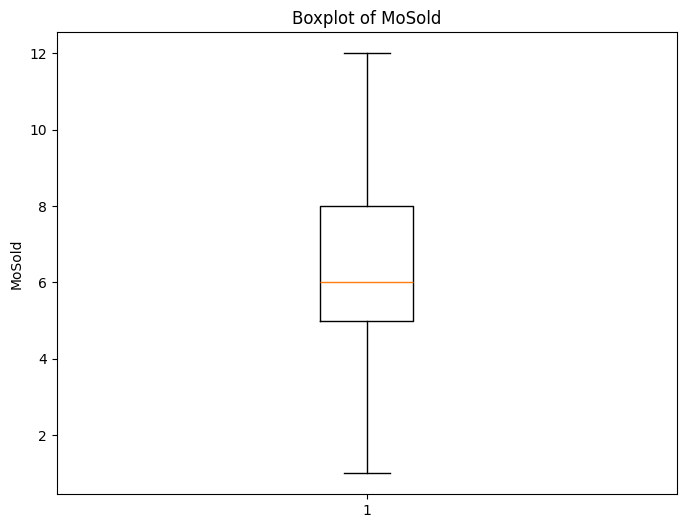

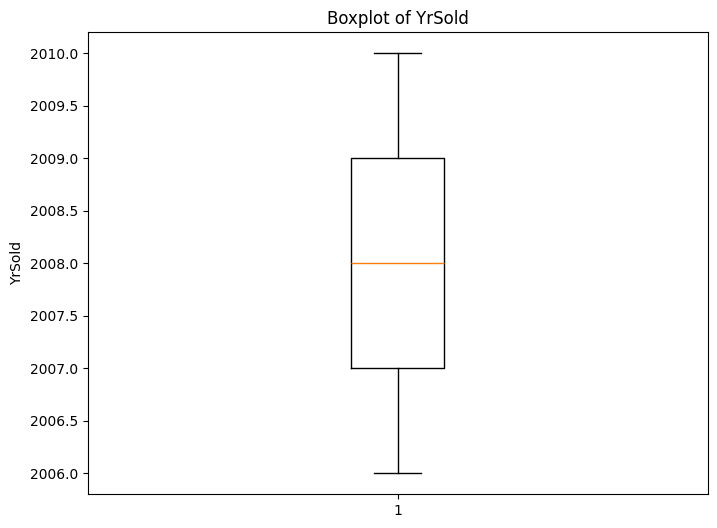

In [22]:
%matplotlib inline
#Check for outliers
for column in numeric_features_all:
  plt.figure(figsize=(8,6))
  plt.boxplot(X[column])
  plt.title(f'Boxplot of {column}')
  plt.ylabel(column)
  plt.show()



We will apply logaritmic transformation for the columns with big outliers. We identify the following columns.

In [23]:
cols_log_all=['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',  'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea',
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Let's see how is the performance of Linear, Ridge, Lasso and Elastic Net models. Let's inspect several values for alpha, using the evaluate_all_linear function on the helper.py module. In this function the default value for li in elastic net is 0.5.


In [24]:
alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X ,y, numeric_columns=numeric_features_all, categorical_columns=categorical_features_all, log_columns=cols_log_all, alpha=alpha)
  print()

alpha = 0.0001
Linear label encoding:      MAE: 15099.967389732374 | RMSLE: 0.12010586660357635
Linear onehot encoding:     MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso label encoding:       MAE: 15077.41995979736  | RMSLE: 0.11999124524467669
Lasso onehot encoding:      MAE: 14367.345413799017 | RMSLE: 0.11831299910241658
Ridge label encoding:       MAE: 15099.965681101809  | RMSLE: 0.12010585799603352
Ridge onehot encoding:      MAE: 14584.153129640305 | RMSLE: 0.12019983805994419
ElasticNet label encoding:  MAE: 15085.724582849929  | RMSLE: 0.12002696148488617
ElasticNet onehot encoding: MAE: 14434.091045588622 | RMSLE: 0.1189827450983832

alpha = 0.001
Linear label encoding:      MAE: 15099.967389732374 | RMSLE: 0.12010586660357635
Linear onehot encoding:     MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso label encoding:       MAE: 15042.504715778803  | RMSLE: 0.11957328381534614
Lasso onehot encoding:      MAE: 14171.871621704966 | RMSLE: 0.11638104950818

We see that the best models is Lasso with one-hot encoding woth alpha=0.001. This is expected, as Lasso performs feature selection. In the following sections, we will analyze the coefficients of the model to identify important features and attempt to improve performance. For this purpose, we will define and train an ElasticNet model:.

In [25]:
elastic_onehot = create_elasticnet_pipeline(
    numeric_features_all,
    categorical_features_all,
    encoding='onehot',
    alpha=0.001,
    l1_ratio=0.5,
    log_columns=cols_log_all
)

In [26]:
# Save the trained pipeline
_, _, elastic_onehot = evaluate_model(X, y, elastic_onehot, return_trained_model=True)

## XGBoost model
Now let's train an XGBoost model baseline. We use X_label which alredy encoded the categorical feature.

In [27]:
xgb_model = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae, xgb_rmsle , xgb_model = evaluate_model(X_label,y, xgb_model)


In [28]:
print(f'XGB_model:      MAE: {xgb_mae}     |      RMSLE:  {xgb_rmsle}')

XGB_model:      MAE: 16154.1181640625     |      RMSLE:  0.13410333444223435


# FEATURE SELECTION

Let's use varios inspection methods to decide which features are more important. We can
* Check the coeficients of our Elastic Net regression models.
* Use the XGBoost gain to help us to select features.
* Use mutual information of the features and the target.

### Linear regression coeficients

Let's get and plot the coeficients for Elastic onehot.

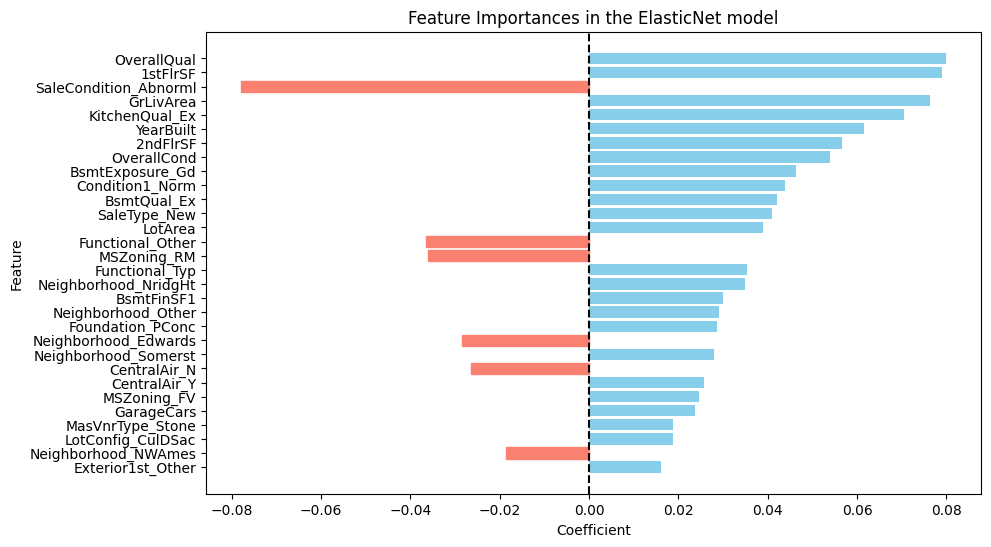

In [29]:

elastic_coef = get_coef_signed(elastic_onehot)
plot_coeficients_importance(elastic_coef, top_n=30, title="Feature Importances in the ElasticNet model")

In [30]:
positive_coeficients = elastic_coef[elastic_coef.coefficient>0]
elastic_features = list({cat.split('_')[0] for cat in positive_coeficients.feature.tolist()} )
X_elastic = X[elastic_features]
X_elastic.shape

(1440, 49)

Selecting features using the Elastic coeficient gives us a list of 49 features. Let's see how our models perform with these features in diferent values of alpha.

In [31]:
print('################ Restricting to the Elastic features #####################\n')
numeric_features_elastic = [col for col in numeric_features_all if col in elastic_features]
categorical_features_elastic = [col for col in categorical_features_all if col in elastic_features]
cols_log_elastic= [col for col in cols_log_all if col in elastic_features]

alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100]

for alpha in alphas:

  print(f'alpha = {alpha}')
  evaluate_all_linear(X_elastic ,y, numeric_columns=numeric_features_elastic, categorical_columns=categorical_features_elastic,
                      log_columns=cols_log_elastic, alpha=alpha)
  print()

################ Restricting to the Elastic features #####################

alpha = 0.0001
Linear label encoding:      MAE: 15344.589561490673 | RMSLE: 0.1217144127109905
Linear onehot encoding:     MAE: 14602.076110893897 | RMSLE: 0.11908052779543576
Lasso label encoding:       MAE: 15340.970248776892  | RMSLE: 0.12166336947071436
Lasso onehot encoding:      MAE: 14456.188790163633 | RMSLE: 0.11829230697802073
Ridge label encoding:       MAE: 15344.589459637555  | RMSLE: 0.12171440942273215
Ridge onehot encoding:      MAE: 14602.064588794889 | RMSLE: 0.11908047250313994
ElasticNet label encoding:  MAE: 15342.456278947628  | RMSLE: 0.12168485138276834
ElasticNet onehot encoding: MAE: 14497.392863564648 | RMSLE: 0.11856200855492717

alpha = 0.001
Linear label encoding:      MAE: 15344.589561490673 | RMSLE: 0.1217144127109905
Linear onehot encoding:     MAE: 14602.076110893897 | RMSLE: 0.11908052779543576
Lasso label encoding:       MAE: 15389.139615596305  | RMSLE: 0.12178073545914353
L

We observe that when restricting our models to the variables selected by elasticNet, there is not significant improvment. Let's see how XGBoost model performs

> Agregar bloque entrecomillado



In [32]:
xgb_model_e = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_e, xgb_rmsle_e , xgb_model_e = evaluate_model(X_label[elastic_features],y, xgb_model_e)

print(f'XGB_model:      MAE: {xgb_mae_e}     |      RMSLE:  {xgb_rmsle_e}')

XGB_model:      MAE: 15696.1123046875     |      RMSLE:  0.13057018061318496


We see that the reduction of these features don't improve siginificantly the XGBoost model.

### XGBoost gain

In [33]:
# Obtener el DataFrame de importancia
xgb_importance_df = get_xgb_feature_importance_df(xgb_model)
xgb_importance_df
# Get a list with the features ordered by importance
xgb_features_ordered =  xgb_importance_df.feature.tolist()

Lets see how our linear models performs by selecting some slices of the XGBoost features

In [34]:
sizes = [10, 20, 30, 35, 40, 45]
features_lists = [xgb_features_ordered[: end] for end in sizes]
for cols in features_lists:
  numeric_features = [col for col in numeric_features_all if col in cols]
  print('size:', len(cols))
  evaluate_all_linear(X[cols] ,y, numeric_columns=numeric_features)
  print()


size: 10
Linear label encoding:      MAE: 19079.73090854113 | RMSLE: 0.15125910134182072
Linear onehot encoding:     MAE: 19079.73090854113 | RMSLE: 0.15125910134182072
Lasso label encoding:       MAE: 19061.861463120233  | RMSLE: 0.1511698205527286
Lasso onehot encoding:      MAE: 19061.861463120233 | RMSLE: 0.1511698205527286
Ridge label encoding:       MAE: 19079.72982698351  | RMSLE: 0.151259098517144
Ridge onehot encoding:      MAE: 19079.72982698351 | RMSLE: 0.151259098517144
ElasticNet label encoding:  MAE: 19074.860037064875  | RMSLE: 0.15121933722345254
ElasticNet onehot encoding: MAE: 19074.860037064875 | RMSLE: 0.15121933722345254

size: 20
Linear label encoding:      MAE: 16679.358537836386 | RMSLE: 0.13249266026183223
Linear onehot encoding:     MAE: 16679.358537836386 | RMSLE: 0.13249266026183223
Lasso label encoding:       MAE: 16667.21371010637  | RMSLE: 0.13251812105471134
Lasso onehot encoding:      MAE: 16667.21371010637 | RMSLE: 0.13251812105471134
Ridge label encod

Let's see how XGBoost performs with these features

In [35]:
xgb_features=xgb_features_ordered[:35]

xgb_model_xgb = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_xgb, xgb_rmsle_xgb , xgb_model_xgb = evaluate_model(X_label.loc[:,xgb_features],y, xgb_model_xgb)

print(f'XGB_model:      MAE: {xgb_mae_xgb}     |      RMSLE:  {xgb_rmsle_xgb}')

XGB_model:      MAE: 15837.1142578125     |      RMSLE:  0.13104161584567425


### Mutual information

In [36]:
# Obtener MI scores
mi_scores = get_mi_scores(X_label, y, discrete_features=[col in categorical_features_all for col in X_label.columns])

mi_scores

,MI Scores
OverallQual,0.573490
GrLivArea,0.473446
GarageArea,0.376723
YearBuilt,0.374290
TotalBsmtSF,0.370171
...,...
3SsnPorch,0.000000
MiscVal,0.000000
PoolArea,0.000000
YrSold,0.000000


We keep the features that have positive MI score

In [37]:
mi_features = mi_scores[mi_scores>0].index.tolist()
numeric_columns_mi = [col for col in numeric_features_all if col in mi_features]
X_mi = X[mi_features]

Let's evaluate the performance of the models with these features.

In [39]:
print('################ Restricting to the mi features #####################')

alphas =[ 0.001, 0.01, 0.1, 1, 10, 50, 75, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X_mi  ,y, numeric_columns=numeric_columns_mi ,alpha=alpha)
  print()

################ Restricting to the mi features #####################
alpha = 0.001
Linear label encoding:      MAE: 15773.97681764251 | RMSLE: 0.12788669618634804
Linear onehot encoding:     MAE: 15773.97681764251 | RMSLE: 0.12788669618634804
Lasso label encoding:       MAE: 15752.430255855024  | RMSLE: 0.12776128210062795
Lasso onehot encoding:      MAE: 15752.430255855024 | RMSLE: 0.12776128210062795
Ridge label encoding:       MAE: 15773.974947260314  | RMSLE: 0.1278866890555144
Ridge onehot encoding:      MAE: 15773.974947260314 | RMSLE: 0.1278866890555144
ElasticNet label encoding:  MAE: 15759.580178101929  | RMSLE: 0.1277851332605531
ElasticNet onehot encoding: MAE: 15759.580178101929 | RMSLE: 0.1277851332605531

alpha = 0.01
Linear label encoding:      MAE: 15773.97681764251 | RMSLE: 0.12788669618634804
Linear onehot encoding:     MAE: 15773.97681764251 | RMSLE: 0.12788669618634804
Lasso label encoding:       MAE: 15985.932556779682  | RMSLE: 0.13027572572744459
Lasso onehot en

In [40]:


xgb_model_mi = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_mi, xgb_rmsle_mi , xgb_model_mi = evaluate_model(X_label.loc[:,mi_features],y, xgb_model_mi)

print(f'XGB_model:      MAE: {xgb_mae_mi}     |      RMSLE:  {xgb_rmsle_mi}')

XGB_model:      MAE: 15792.671875     |      RMSLE:  0.13081140953047415


**CONCLUSION:** Among the three feature selection methods, we conclude that the most effective approach was using the Elastic Net coefficients. We will keep these selected features and construct new ones in the next section.

#DEFINING NEW FEATURES

Let's begin by tuning alpha and l1 of a elastic net model with the restriction of elastic features and some combinations of the numerical. Recall that we hace the series `elastic_features` with numeric columns `numeric_features_elastic` and categorical `categorical_features_elastic`.



In [41]:
# Product tuples
product_tuples = [
    ('GrLivArea', 'OverallQual'),
    #('TotalBsmtSF', 'OverallQual'),
    #('1stFlrSF', '2ndFlrSF'),
    ('WoodDeckSF', 'OpenPorchSF'),
    #('OpenPorchSF', 'ScreenPorch'),
    #('EnclosedPorch', '3SsnPorch'),
    #('FullBath', 'GarageCars'),
    ('BsmtFullBath', 'FullBath')
]

# Ratio tuples
ratio_tuples = [
    #('GrLivArea', 'TotalBsmtSF'),
    ('1stFlrSF', '2ndFlrSF'),
    ('OpenPorchSF', 'EnclosedPorch'),
    #('WoodDeckSF', 'ScreenPorch'),
    ('FullBath', 'HalfBath'),
    #('BsmtFullBath', 'FullBath')
]

In [53]:
X_el_interac, numeric_features_el_inter = add_interactions(X_elastic, product_tuples, ratio_tuples=ratio_tuples)
X_interac, numeric_features_inter = add_interactions(X, product_tuples, ratio_tuples=ratio_tuples)


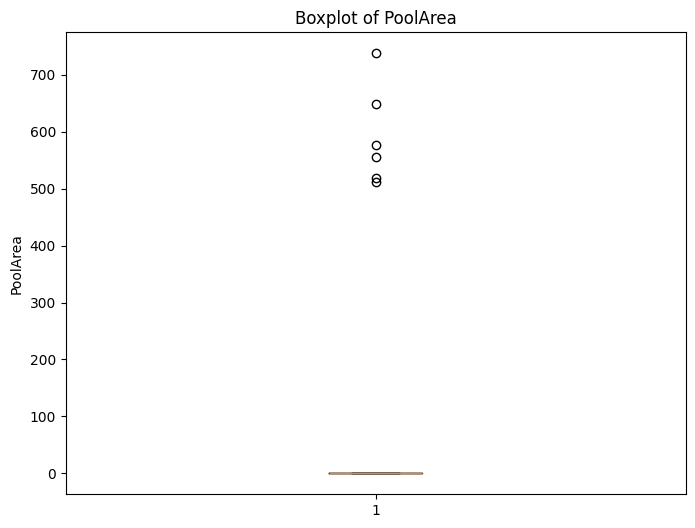

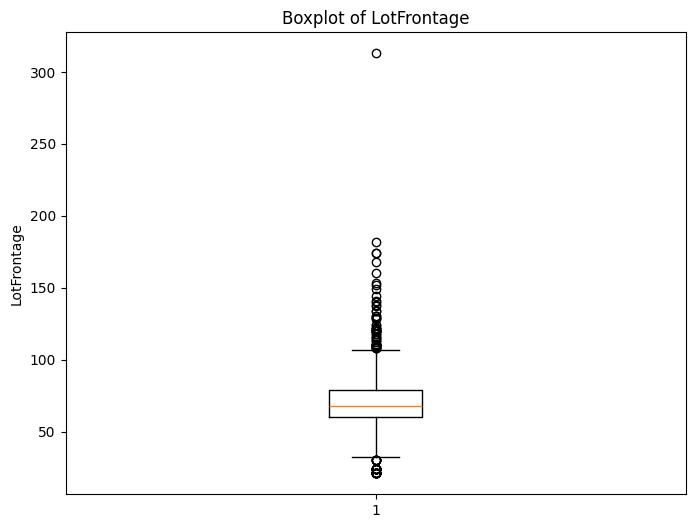

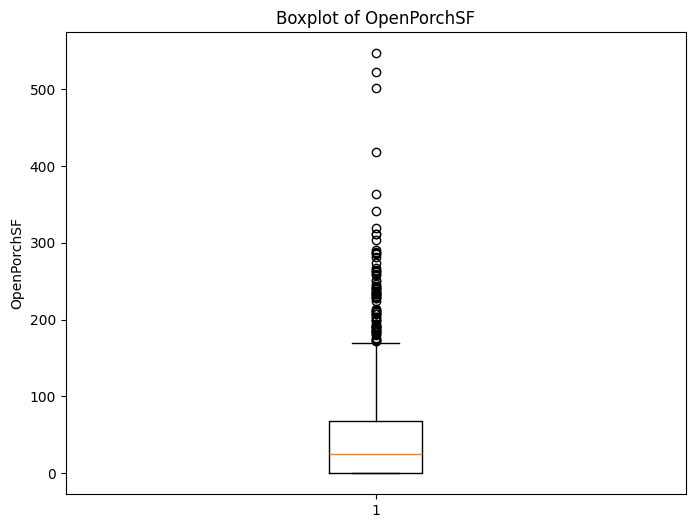

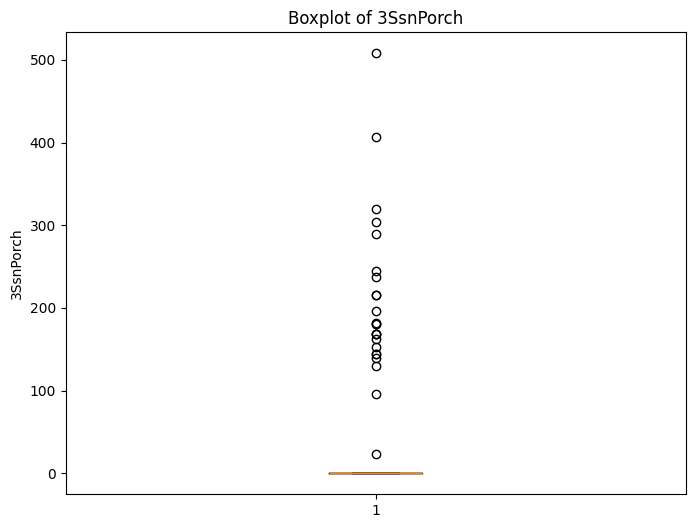

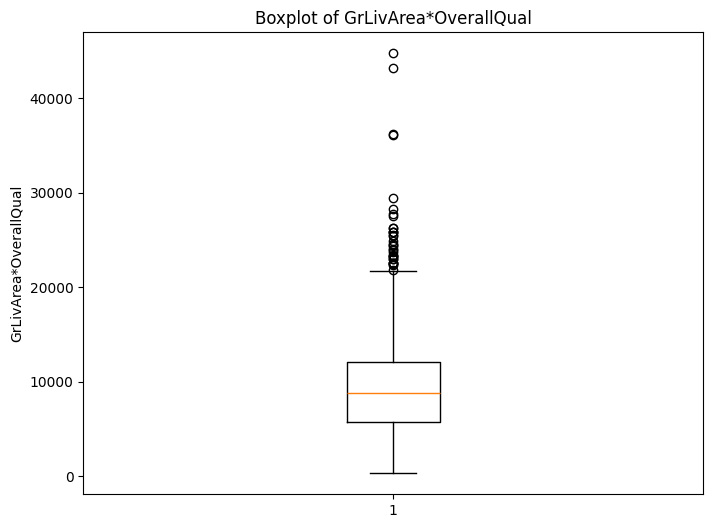

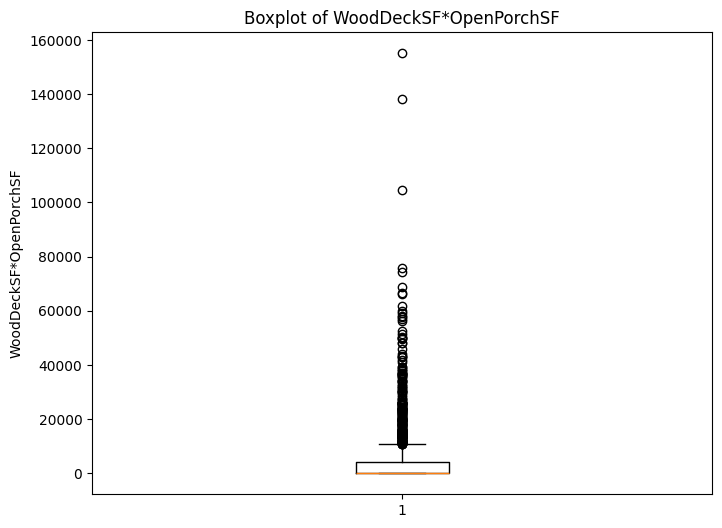

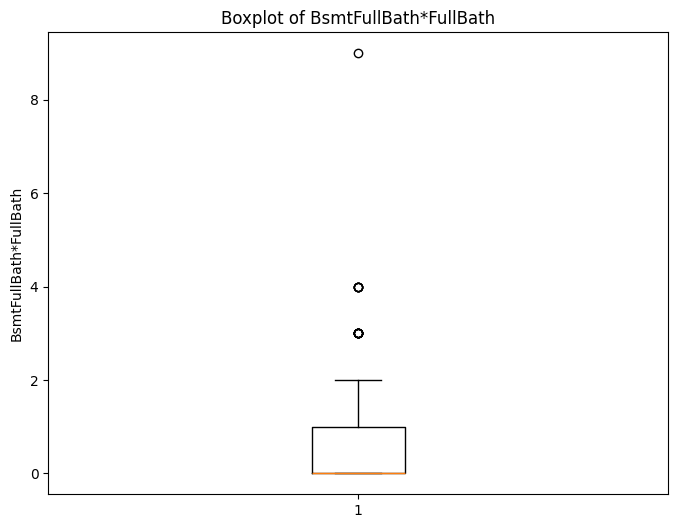

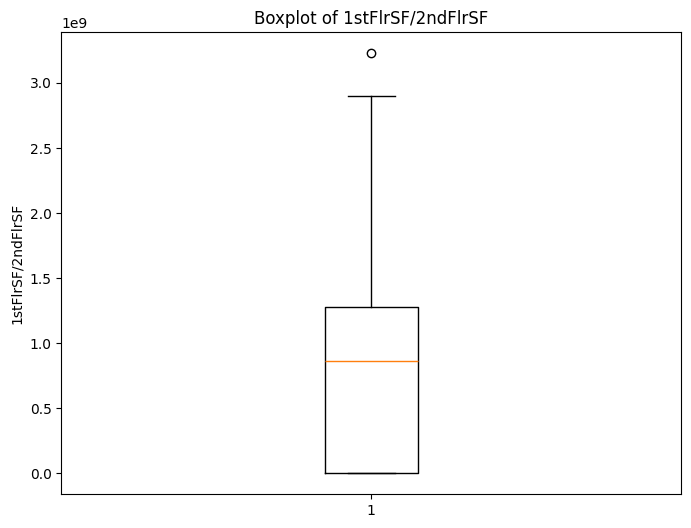

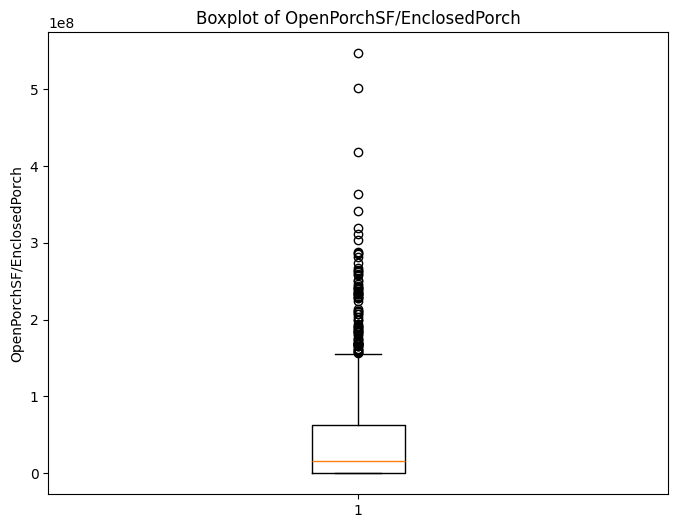

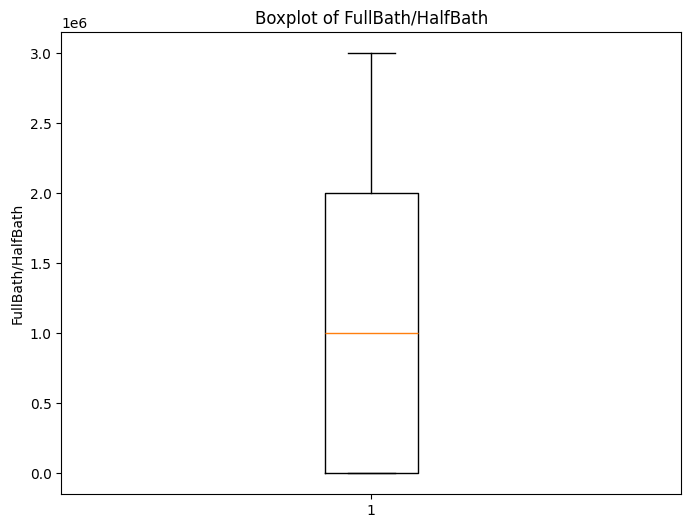

In [43]:
# Identificar nuevas columnas (las de interacciones)
numeric_new_el = [col for col in numeric_features_el_inter if col not in numeric_features]

# Boxplots para revisar outliers en las nuevas columnas
for column in numeric_new_el:
    plt.figure(figsize=(8, 6))
    plt.boxplot(X_interac[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()


In [50]:
cols_log_interac = cols_log_all+ ['GrLivArea*OverallQual', 'WoodDeckSF*OpenPorchSF', 'BsmtFullBath*FullBath', "OpenPorchSF/EnclosedPorch"]
cols_log_elastic_interac = list(set(cols_log_elastic) & set(cols_log_interac))

In [51]:
print('################ Evaluating new features with elastic features #####################\n')

alphas =[0.0001, 0.001, 0.01, 1 , 10, 50, 100]

for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X_interac ,y, numeric_columns=numeric_features_inter, categorical_columns=categorical_features_elastic,
                      log_columns=cols_log_elastic_interac, alpha=alpha)
  print()

################ Evaluating new features with elastic features #####################

alpha = 0.0001
Linear label encoding:      MAE: 14910.419021974576 | RMSLE: 0.1202278341058199
Linear onehot encoding:     MAE: 14389.910049225788 | RMSLE: 0.11832947873072068
Lasso label encoding:       MAE: 14877.470882024854  | RMSLE: 0.12010718648971073
Lasso onehot encoding:      MAE: 14230.44455599542 | RMSLE: 0.11751199219947758
Ridge label encoding:       MAE: 14910.41848138724  | RMSLE: 0.12022783040430647
Ridge onehot encoding:      MAE: 14389.89798401026 | RMSLE: 0.11832941994741719
ElasticNet label encoding:  MAE: 14893.336552530931  | RMSLE: 0.12016269945610406
ElasticNet onehot encoding: MAE: 14276.06893764968 | RMSLE: 0.11778385093802839

alpha = 0.001
Linear label encoding:      MAE: 14910.419021974576 | RMSLE: 0.1202278341058199
Linear onehot encoding:     MAE: 14389.910049225788 | RMSLE: 0.11832947873072068
Lasso label encoding:       MAE: 14747.602861133368  | RMSLE: 0.1200572798344

In [54]:
print('################ Evaluating new features with all features #####################\n')

alphas =[0.001, 0.001, 0.01, 1 , 10, 50, 100]

for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X_interac ,y, numeric_columns=numeric_features_all, categorical_columns=categorical_features_all,
                      log_columns=cols_log_interac, alpha=alpha)
  print()

################ Evaluating new features with all features #####################

alpha = 0.001
Linear label encoding:      MAE: 14975.012797268817 | RMSLE: 0.11982729525594318
Linear onehot encoding:     MAE: 14579.289149138827 | RMSLE: 0.12047266226316887
Lasso label encoding:       MAE: 15051.25937934947  | RMSLE: 0.11954926500958545
Lasso onehot encoding:      MAE: 14180.493262049711 | RMSLE: 0.11648174053772771
Ridge label encoding:       MAE: 14975.010080353944  | RMSLE: 0.11982717964426597
Ridge onehot encoding:      MAE: 14579.098821928745 | RMSLE: 0.12047052627553166
ElasticNet label encoding:  MAE: 15029.615230011386  | RMSLE: 0.11973820641901252
ElasticNet onehot encoding: MAE: 14152.021796237794 | RMSLE: 0.11671390912032226

alpha = 0.001
Linear label encoding:      MAE: 14975.012797268817 | RMSLE: 0.11982729525594318
Linear onehot encoding:     MAE: 14579.289149138827 | RMSLE: 0.12047266226316887
Lasso label encoding:       MAE: 15051.25937934947  | RMSLE: 0.11954926500958

In [ ]:
elastic_best_coef = elastic_coef[elastic_coef.coefficient>0]
elastic_features = list({cat.split('_')[0] for cat in positive_coeficients.feature.tolist()} )
X_elastic = X[elastic_features]
X_elastic.shape

#BEST MODEL AND SUBMIT GENERTOR

In [58]:


pipeline_best = create_ridge_pipeline(
    numeric_columns=numeric_features_all,
    categorical_columns=categorical_features_all,
    encoding='onehot',
    log_columns=cols_log_all,
    alpha=50,
    #l1_ratio=0.5
)

MAE, LMSE, best_model = evaluate_model(X, y, pipeline_best, return_trained_model=True)
MAE, LMSE

(14324.789071285611, np.float64(0.11688890742870461))

In [59]:
import pandas as pd
import numpy as np

# 1️⃣ Load preprocessed test set and raw test set
X_test = pd.read_csv("test_pre.csv")       # preprocessed features
X_test_interac, _ = add_interactions(X_test[elastic_features], product_tuples, ratio_tuples=ratio_tuples)
df_test_raw = pd.read_csv("test_raw.csv")  # original file with Ids

# 2️⃣ Predict using trained model
# If your model was trained with log1p(SalePrice)
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # revert log1p transformation

# 3️⃣ Create submission DataFrame
submission = pd.DataFrame({
    "Id": df_test_raw["Id"],  # use Id from original file
    "SalePrice": y_pred
})

# 4️⃣ Save submission CSV
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")



Submission file created: submission.csv
